# Autoencoders

🎯 **Exercise objectives**
- Discover ***autoencoders***
- Get a deeper understanding of CNNs

<hr>

👉 There exists a very particular architecture in Deep Learning called **`Autoencoders`**. Autoencoders are Neural Network architectures trained to return **outputs that are as similar as possible to the original inputs fed to them**. Why would we do that?  

Before answering the question _"why"_, let's answer the question _"how"_.

👩🏻‍🏫 <u>***How does an autoencoder work ?***</u>

There are two parts in an autoencoder: the  **`encoder`** and the **`decoder`**.

1. In the encoder, we will make the information flow through different dense layers with a decreasing number of neurons. It will create a **`bottleneck`** where the information is compressed.

2. In the decoder, we will try to recreate the original data based on the compressed data.

🔥 <u>***Why is it powerful or useful?***</u>

If it works well, it means two important things:

* ✅ We can afford to **compress our dataset** and use a compressed version of it when fitting another Neural Network!

* ✅ The **information contained in the bottleneck** - i.e. the data compressed in a low-dimensional layer - **accurately captures the patterns of our dataset** and the autoencoder is able to decode the compressed information!

🌠 <u>**Applications:**</u>
- Image compression
- Denoising (cf. Google Pixel phones...)
- Image generation!


<img src='https://wagon-public-datasets.s3.amazonaws.com/data-science-images/DL/autoencoder.png'>

## Google Colab Setup

Repeat the same process from the last challenge to upload your challenge folder and open your notebook:

1. access your [Google Drive](https://drive.google.com/)
2. go into the Colab Notebooks folder
3. drag and drop this challenge's folder into it
4. right-click the notebook file and select `Open with` $\rightarrow$ `Google Colaboratory`

Don't forget to enable GPU acceleration!

`Runtime` $\rightarrow$ `Change runtime type` $\rightarrow$ `Hardware accelerator` $\rightarrow$ `GPU`

When this is done, run the cells below and get to work!

In [1]:
# Mount GDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Put Colab in the context of this challenge
import os

# os.chdir allows you to change directories, like cd in the Terminal
os.chdir('/content/drive/MyDrive/Colab Notebooks/')

You are now good to go, proceed with the challenge! Don't forget to copy everything back to your PC to upload to Kitt 🚀

## (0) The MNIST Dataset

In this notebook, we will train an auto-encoder to work on 28x28 grey images from the MNIST dataset, available in Keras. Run the cells below

In [3]:
from tensorflow.keras.datasets import mnist

(images_train, labels_train), (images_test, labels_test) = mnist.load_data()
print(images_train.shape)
print(images_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


In [4]:
# Add a channels for the colors and normalize data
X_train = images_train.reshape((60000, 28, 28, 1)) / 255.
X_test = images_test.reshape((10000, 28, 28, 1)) / 255.

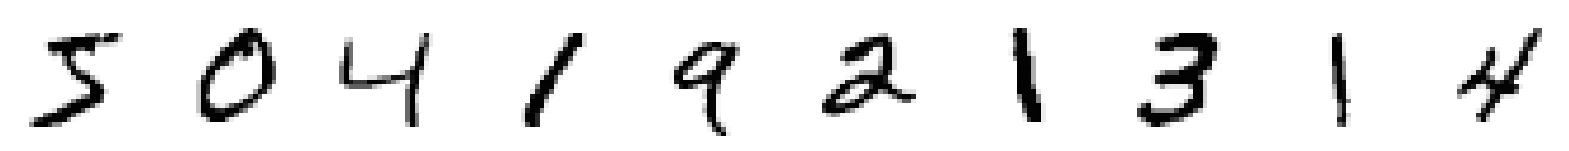

In [5]:
# Plot some images
import matplotlib.pyplot as plt

f, axs = plt.subplots(1, 10, figsize=(20, 4))
for i, ax in enumerate(axs):
    ax.axis('off')
    ax.imshow(X_train[i].reshape(28, 28), cmap='Greys')

plt.show()

## (1) The encoder

🎁 First, we built the "Encoder" part for you.

👉  Notice how similar it looks compared to a Convolutional Classifier with **latent_dimension** neurons at the end. However, we using the "tanh" activation function in the final dense layer instead of "relu".

In [60]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def build_encoder(latent_dimension):
    '''returns an encoder model, of output_shape equals to latent_dimension'''
    encoder = Sequential()

    encoder.add(Conv2D(8, (2,2), input_shape=(28, 28, 1), activation='relu'))
    encoder.add(MaxPooling2D(2))

    encoder.add(Conv2D(16, (2, 2), activation='relu'))
    encoder.add(MaxPooling2D(2))

    encoder.add(Conv2D(32, (2, 2), activation='relu'))
    encoder.add(MaxPooling2D(2))

    encoder.add(Flatten())
    encoder.add(Dense(latent_dimension, activation='tanh'))

    return encoder

❓ **Question: building an encoder** ❓

Build your encoder with **`latent_dimension = 2`** and look at the number of parameters.

In [12]:
# YOUR CODE HERE
def build_encoder_2(latent_dimension=2):
    encoder = Sequential()

    encoder.add(Conv2D(10,kernel_size=5,input_shape=(28,28,1),activation='relu'))
    encoder.add(MaxPooling2D(2))

    encoder.add(Conv2D(12,kernel_size=4,activation='relu'))
    encoder.add(MaxPooling2D(2))

    encoder.add(Conv2D(14,kernel_size=3,activation='relu'))
    encoder.add(MaxPooling2D(2))

    encoder.add(Flatten())
    encoder.add(Dense(latent_dimension,activation='tanh'))

    return encoder

In [13]:
encoder = build_encoder_2(2)
encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 24, 24, 10)        260       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 10)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 12)          1932      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 12)          0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 14)          1526      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 1, 1, 14)         

## (2) Decoder

It's your turn to build the decoder this time!

We need to build a 🔥 **`reversed CNN` 🔥** that
* takes a dense layer as input,
* and outputs an image of shape $ (28,28,1) $ similar to our MNIST images.

📚 For this purpose, we will use a new layer called <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">**`Conv2DTranspose`**</a> 📚
    
The name of this layer speaks for itself: it performs the opposite of a convolution operation!

💡 We will follow this strategy:
* Start by reshaping the Dense Input Layer into an Image of shape $(7,7,..)$
* Then apply the `Conv2DTranspose` operation with ***strides = 2*** to double the output shape to $(14,14,..)$
* then add another Conv2DTranpose layer on top of the first one to make it $(28,28,1)$.

<hr>

❓ **Question: the architecture of a decoder** ❓


Define a **`decoding architecture`** in the method below as follows:
- a *Dense* layer with:
    - $7 \times 7 \times 8$ neurons,
    - *input_shape* = (latent_dimension, )
    - *tanh* activation function.
- a *Reshape* layer that reshapes to $(7, 7, 8)$ tensors
- a *Conv2DTranspose* with:
    - $8$ filters,
    - $(2,2)$ kernels,
    - strides of $2$,
    - padding *same*
    - _relu_ activation function
- a second Conv2DTranspose layer with:
    - $1$ filter,
    - $(2,2)$ kernels,
    - strides of $2$,
    - padding _same_,
    - _relu_ activation function

❓ **Question: buiding a decoder** ❓

Build your decoder with **`latent_dimension = 2`** and check that it outputs images of same shape than the encoder input

In [19]:
# YOUR CODE HERE
from tensorflow.keras.layers import Reshape, Conv2DTranspose

def build_decoder(latent_dimension):
    decoder = Sequential()
    decoder.add(Dense(7*7*8,input_shape=(latent_dimension,),activation='tanh'))
    decoder.add(Reshape((7,7,8)))

    decoder.add(Conv2DTranspose(8,(2,2),strides=2,padding='same',activation='relu'))

    decoder.add(Conv2DTranspose(1, kernel_size=(2, 2), strides=2, padding='same', activation='relu'))

    return decoder

In [20]:
decoder = build_decoder(2)

In [21]:
decoder.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 392)               1176      
                                                                 
 reshape (Reshape)           (None, 7, 7, 8)           0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 8)         264       
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 1)         33        
 Transpose)                                                      
                                                                 
Total params: 1473 (5.75 KB)
Trainable params: 1473 (5.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## (3) Auto-Encoder

🎉 We can now **concatenate** both **`the encoder and the decoder`** thanks to the **`Model`** class in Keras, using the **`Functional API`**.

In [22]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input

def build_autoencoder(encoder, decoder):
    inp = Input((28, 28,1))
    encoded = encoder(inp)
    decoded = decoder(encoded)
    autoencoder = Model(inp, decoded)
    return autoencoder

❓ **Questions** ❓

* Try to understand syntax above 👆
* Build your autoencoder
* Have a look at the number of parameters

In [23]:
# YOUR CODE HERE
autoencoder = build_autoencoder(encoder,decoder)

In [24]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 sequential_2 (Sequential)   (None, 2)                 3748      
                                                                 
 sequential_5 (Sequential)   (None, 28, 28, 1)         1473      
                                                                 
Total params: 5221 (20.39 KB)
Trainable params: 5221 (20.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


❓ **Question: Compiling an autoencoder** ❓

Define a method which compiles your model. Pick an appropriate loss.

<u><i>Think carefully:</i></u> 🤔 On which mathematical object are we going to compare *predictions* and the *ground truth* for the computation of the loss function and the metrics?


<details>
    <summary><i>Answer</i></summary>

It should compare two images (Black and White in our case), pixel-by-pixel!
    
The MSE loss seems to be an appropriate loss function for pixel-by-pixel error minimization.
</details>

In [25]:
# YOUR CODE HERE
def compile_model(model):
  model.compile(optimizer='adam',loss='mse',metrics='mse')
  return model

❓ **Question: Training an autoencoder** ❓  

* Compile your model and fit it with `batch_size = 32` and `epochs = 20`.
* What is the label `y_train` in this case?

<i>Note:</i> Don't waste your time fighting overfitting in this challenge, you will have time to care about this during the project weeks :)

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

In [29]:
y_train,y_test=labels_train,labels_test

In [31]:
# YOUR CODE HERE
es=EarlyStopping(patience=3)
model = build_autoencoder(encoder,decoder)
model = compile_model(model)

history = model.fit(X_train,y_train,epochs=500,validation_split=0.2,batch_size=32,callbacks=[es],verbose=0)

In [32]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 8.4173 - mse: 8.4173


[8.417313575744629, 8.417304992675781]

❓ **Question: Encoding the dataset** ❓

* Using only the encoder part of the network, encode your dataset and save it under `X_encoded` .
    * Each image is now represented by two values (that correspond to the dimension of the latent space, of the bottleneck; aka the `latent_dimension`.

In [38]:
# YOUR CODE HERE
X_encoded = encoder.predict(X_train)
X_encoded.shape

1875/1875 [==============================] - 3s 2ms/step


(60000, 2)

🤔 Where are we after running the encoder?

* Each image was compressed into a 2D space.
* Each of these handwritten digit have a given label, between 0 and 9, but the goal here is not to classify these pictures like in the first challenge but to **reconstruct the original image before the compression**.

❓ **Question: Visualizing handwritten digits in the latent space** ❓

Scatterplot the encoded data (only a small fraction of the encoded dataset for visibility purposes...)
- Each point of the scatter plot  corresponds to an encoded image
- Color the dots according to their respective labels (digit representation):
    - for instance, all the "4"s should be represented by a color on this scatter plot...
    - ...while the "5" should be represented by another color
    - choose a set of [`qualitative colormaps`](https://matplotlib.org/stable/gallery/color/colormap_reference.html)

What do you remark about this plot?

In [36]:
labels_train[:300]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
       3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5,
       6, 1, 0, 0, 1, 7, 1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9,
       0, 4, 6, 7, 4, 6, 8, 0, 7, 8, 3, 1, 5, 7, 1, 7, 1, 1, 6, 3, 0, 2,
       9, 3, 1, 1, 0, 4, 9, 2, 0, 0, 2, 0, 2, 7, 1, 8, 6, 4, 1, 6, 3, 4,
       5, 9, 1, 3, 3, 8, 5, 4, 7, 7, 4, 2, 8, 5, 8, 6, 7, 3, 4, 6, 1, 9,
       9, 6, 0, 3, 7, 2, 8, 2, 9, 4, 4, 6, 4, 9, 7, 0, 9, 2, 9, 5, 1, 5,
       9, 1, 2, 3, 2, 3, 5, 9, 1, 7, 6, 2, 8, 2, 2, 5, 0, 7, 4, 9, 7, 8,
       3, 2, 1, 1, 8, 3, 6, 1, 0, 3, 1, 0, 0, 1, 7, 2, 7, 3, 0, 4, 6, 5,
       2, 6, 4, 7, 1, 8, 9, 9, 3, 0, 7, 1, 0, 2, 0, 3, 5, 4, 6, 5, 8, 6,
       3, 7, 5, 8, 0, 9, 1, 0, 3, 1, 2, 2, 3, 3, 6, 4, 7, 5, 0, 6, 2, 7,
       9, 8, 5, 9, 2, 1, 1, 4, 4, 5, 6, 4, 1, 2, 5, 3, 9, 3, 9, 0, 5, 9,
       6, 5, 7, 4, 1, 3, 4, 0, 4, 8, 0, 4, 3, 6], d

In [39]:
labels_train.shape

(60000,)

## (4) Application: Image generation

❓ **Questions: Generate new digits** ❓

* Let's create some new digits!
* Run the following code editing the latent coordinates.
* Play with the coordinates start with ones from the graph above.
* For example [0.75, 0.75] is the "zero" area with latent space (don't forget to experiment outside the boundaries of our original dataset)

In [42]:
import numpy as np

1/1 [==============================] - 0s 86ms/step


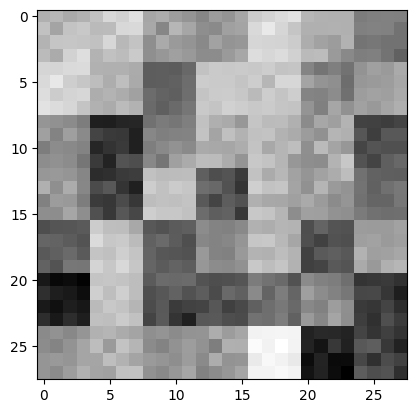

In [43]:
latent_coords = np.array([[0.75, -0.75]])
generated_img = decoder.predict(latent_coords)
plt.imshow(generated_img.reshape(28,28), cmap='Greys')

❗️ We can reuse the decoder of auto encoders as one of the simplest forms of generative deep learning. When we enter coordinates that were not in the training dataset **we are creating never seen before digits!**

## (5) Application: Image denoising

❓ **Questions: Creating some noise in the dataset** ❓

* Let's add some noise to the input data.
* Run the following code
* Plot some handwritten digits and their noisy versions

In [44]:
import numpy as np

noise_factor = 0.5

X_train_noisy = X_train + noise_factor * np.random.normal(0., 1., size=X_train.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(0., 1., size=X_test.shape)

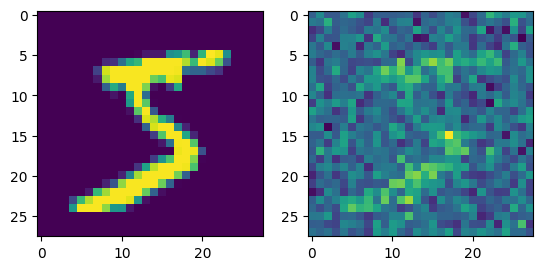

In [47]:
# YOUR CODE HERE
plt.subplot(1,2,1)
plt.imshow(X_train[0])
plt.subplot(1,2,2)
plt.imshow(X_train_noisy[0])

❓ **Question: decoding the noisy pictures** ❓

* Reinitialize your autoencoder (with a latent space of 2)
* Train it again, this time using the noisy train dataset instead of the normal train dataset
    * *Keep `batch_size = 32` and `epochs = 5`*
* What do you expect if you run the autoencoder on the noisy data instead of the original data in terms of performance?

In [48]:
# YOUR CODE HERE
model = build_autoencoder(encoder,decoder)
model = compile_model(model)
history = model.fit(X_train_noisy,y_train,epochs=5,
                    validation_split=0.3, batch_size=32,callbacks=[es])

Epoch 1/5
1313/1313 [==============================] - 12s 6ms/step - loss: 8.3724 - mse: 8.3724 - val_loss: 8.3108 - val_mse: 8.3108
Epoch 2/5
1313/1313 [==============================] - 9s 7ms/step - loss: 8.3733 - mse: 8.3733 - val_loss: 8.3217 - val_mse: 8.3217
Epoch 3/5
1313/1313 [==============================] - 9s 7ms/step - loss: 8.3741 - mse: 8.3741 - val_loss: 8.3343 - val_mse: 8.3343
Epoch 4/5
1313/1313 [==============================] - 9s 7ms/step - loss: 8.3743 - mse: 8.3743 - val_loss: 8.3154 - val_mse: 8.3154


❓ **Question: comparing the noisy test images with the denoised images** ❓

For some noisy test images, predict the denoised images and plot the results side by side...

In [50]:
pred = model.predict(X_test_noisy)

313/313 [==============================] - 1s 2ms/step


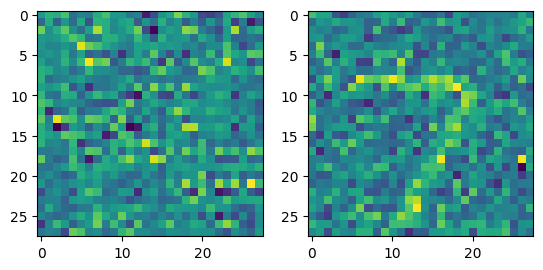

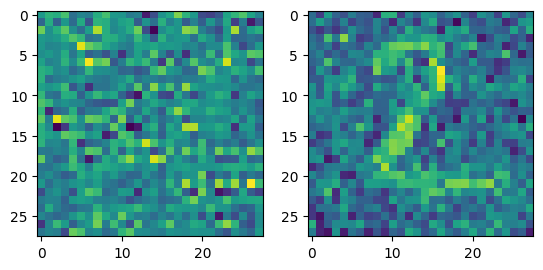

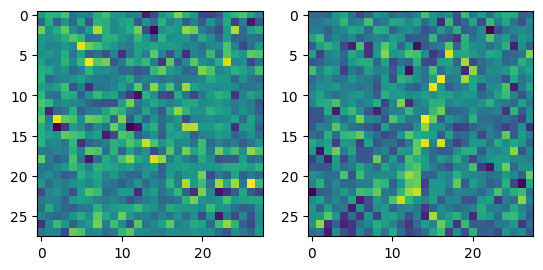

In [59]:
# YOUR CODE HERE
for i in range(3):
    plt.subplot(1,2,1)
    plt.imshow(pred[i])
    plt.subplot(1,2,2)
    plt.imshow(X_test_noisy[i])
    plt.show();

❓ **Question: choosing the "correct" latent_dimension** ❓

Now, try to evaluate which **`latent_dimension`** is the most suitable in order to have **`the best image reconstruction preprocess`** $ \Leftrightarrow $ How to remove as much noise as possible in the noisy dataset using the latent dimension?`

In [67]:
# YOUR ANSWER HERE
encoder = build_encoder(12)
decoder = build_decoder(12)
auto = build_autoencoder(encoder,decoder)
model = compile_model(auto)
history = model.fit(X_train_noisy,y_train,epochs=5,validation_split=0.3,
                    batch_size=32,callbacks=[es])

Epoch 1/5
1313/1313 [==============================] - 13s 7ms/step - loss: 10.1864 - mse: 10.1864 - val_loss: 8.3169 - val_mse: 8.3169
Epoch 2/5
1313/1313 [==============================] - 10s 7ms/step - loss: 8.3731 - mse: 8.3731 - val_loss: 8.3167 - val_mse: 8.3167
Epoch 3/5
1313/1313 [==============================] - 8s 6ms/step - loss: 8.3733 - mse: 8.3733 - val_loss: 8.3198 - val_mse: 8.3198
Epoch 4/5
1313/1313 [==============================] - 9s 7ms/step - loss: 8.3765 - mse: 8.3765 - val_loss: 8.3129 - val_mse: 8.3129
Epoch 5/5
1313/1313 [==============================] - 8s 6ms/step - loss: 8.3741 - mse: 8.3741 - val_loss: 8.3124 - val_mse: 8.3124


313/313 [==============================] - 1s 2ms/step


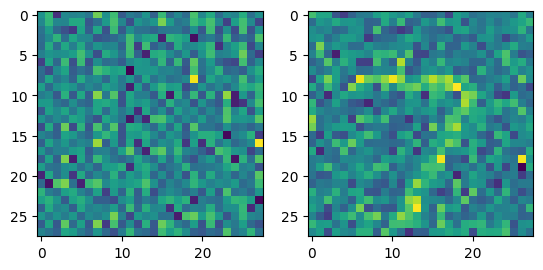

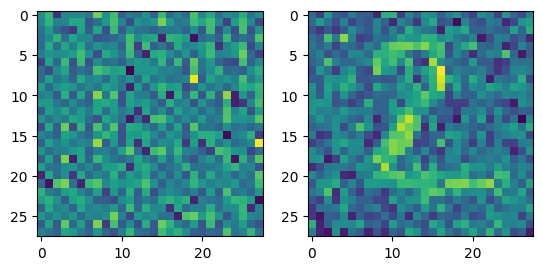

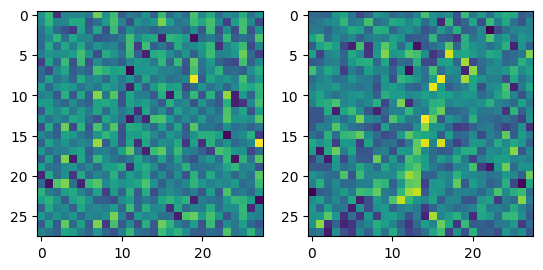

In [68]:
pred = model.predict(X_test_noisy)
for i in range(3):
    plt.subplot(1,2,1)
    plt.imshow(pred[i])
    plt.subplot(1,2,2)
    plt.imshow(X_test_noisy[i])
    plt.show();

🥡 <b><u>Conclusion</u></b>


* It is obvious that:
    * if you compress your pictures of size $ 28 \times 28 $ into a 1D space, you will lose a ton of information.
    * if you compress them into a $ 28 \times 28 = 784$ -space, you are actually not compressing them
    
* We can still use this graph of **Loss vs. Latent dimensions** reading it from right to left to decide in which latent space it would be advisable to compress the pictures without losing to much information: `latent_space = 8` seems a sweat spot here using the Elbow Method.

---

🏁 **Congratulations** 🏁

1. Download this notebook from your `Google Drive` or directly from `Google Colab`
2. Drag-and-drop it from your `Downloads` folder to your local challenge folder


💾 Don't forget to push your code

3. Follow the usual procedure on your terminal inside the challenge folder:
      * *git add autoencoder.ipynb*
      * *git commit -m "I am the god of Transfer Learning"*
      * *git push origin master*

*Hint*: To find where this Colab notebook has been saved, click on `File` $\rightarrow$ `Locate in Drive`.

😉 That was the last challenge of this module!